In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Libraries

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


##Import Dataset and explore it


###The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/DWM/mbti_1_updated.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
data.describe(include='O')

,type,posts
count,17350,17350
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,3664,2


In [ ]:
data['type'].value_counts()

INFP    3664
INFJ    2940
INTP    2608
INTJ    2182
ENTP    1370
ENFP    1350
ISTP     674
ISFP     542
ENTJ     462
ISTJ     410
ENFJ     380
ISFJ     332
ESTP     178
ESFP      96
ESFJ      84
ESTJ      78
Name: type, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17350 entries, 0 to 17349
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    17350 non-null  object
 1   posts   17350 non-null  object
dtypes: object(2)
memory usage: 271.2+ KB


In [ ]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

##Splitting Data 

In [ ]:
# Stratify split to ensure equal distribution of data

train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

##Cleaning the text data

In [ ]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [ ]:
train_data.posts,train_length=clear_text(train_data)

100%|██████████| 13880/13880 [00:07<00:00, 1897.79it/s]


In [ ]:
test_data.posts,test_length=clear_text(test_data)

100%|██████████| 3470/3470 [00:01<00:00, 1894.74it/s]


##Visualisation

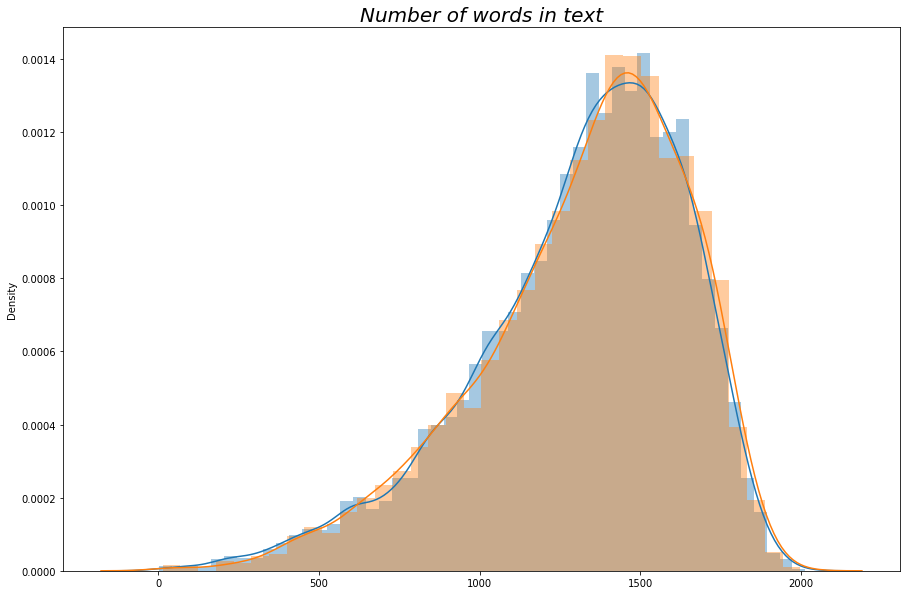

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

In [ ]:
px.pie(train_data,names='type',title='Personality type',hole=0.25)

##Tokenizing words

In [ ]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [ ]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x7f638b1c1050>)

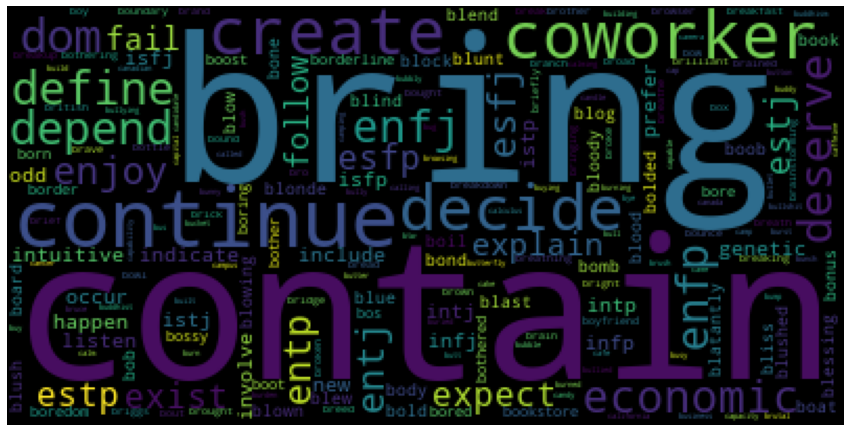

In [ ]:
feature_names=vectorizer.get_feature_names()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(wc)

In [ ]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [ ]:
train_post.shape

(13880, 5000)

In [ ]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

##Model Selection

In [ ]:
models_accuracy={}

##Logistic Regression

In [ ]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.83      0.30      0.44       304
        ENFP       0.82      0.72      0.77      1080
        ENTJ       0.91      0.48      0.63       370
        ENTP       0.82      0.74      0.78      1096
        ESFJ       0.80      0.12      0.21        67
        ESFP       0.00      0.00      0.00        77
        ESTJ       0.00      0.00      0.00        62
        ESTP       0.81      0.18      0.29       142
        INFJ       0.78      0.86      0.82      2352
        INFP       0.72      0.92      0.81      2931
        INTJ       0.78      0.83      0.80      1746
        INTP       0.77      0.89      0.82      2086
        ISFJ       0.88      0.46      0.60       266
        ISFP       0.88      0.48      0.62       434
        ISTJ       0.85      0.49      0.62       328
        ISTP       0.86      0.69      0.76       539

    accuracy                           0.78     1

In [ ]:
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       0.81      0.22      0.35        76
        ENFP       0.79      0.60      0.68       270
        ENTJ       0.85      0.42      0.57        92
        ENTP       0.73      0.70      0.71       274
        ESFJ       1.00      0.12      0.21        17
        ESFP       0.00      0.00      0.00        19
        ESTJ       0.00      0.00      0.00        16
        ESTP       1.00      0.19      0.33        36
        INFJ       0.74      0.77      0.75       588
        INFP       0.67      0.92      0.77       733
        INTJ       0.73      0.77      0.75       436
        INTP       0.70      0.86      0.77       522
        ISFJ       0.86      0.27      0.41        66
        ISFP       0.84      0.34      0.49       108
        ISTJ       0.79      0.41      0.54        82
        ISTP       0.84      0.64      0.73       135

    accuracy                           0.72      34

In [ ]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))
print(models_accuracy)

{'logistic regression': 0.7193083573487031}


##Multinomial Naive Bayes

In [ ]:
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

MultinomialNB()

In [ ]:
print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       304
        ENFP       0.92      0.14      0.24      1080
        ENTJ       0.00      0.00      0.00       370
        ENTP       0.81      0.24      0.37      1096
        ESFJ       0.00      0.00      0.00        67
        ESFP       0.00      0.00      0.00        77
        ESTJ       0.00      0.00      0.00        62
        ESTP       0.00      0.00      0.00       142
        INFJ       0.57      0.69      0.62      2352
        INFP       0.41      0.92      0.56      2931
        INTJ       0.73      0.56      0.63      1746
        INTP       0.61      0.72      0.66      2086
        ISFJ       0.00      0.00      0.00       266
        ISFP       1.00      0.00      0.01       434
        ISTJ       0.71      0.02      0.03       328
        ISTP       1.00      0.04      0.08       539

    accuracy                           0.52     1

In [ ]:
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        76
        ENFP       0.93      0.05      0.10       270
        ENTJ       0.00      0.00      0.00        92
        ENTP       0.64      0.14      0.23       274
        ESFJ       0.00      0.00      0.00        17
        ESFP       0.00      0.00      0.00        19
        ESTJ       0.00      0.00      0.00        16
        ESTP       0.00      0.00      0.00        36
        INFJ       0.48      0.59      0.53       588
        INFP       0.37      0.89      0.52       733
        INTJ       0.67      0.42      0.51       436
        INTP       0.50      0.61      0.55       522
        ISFJ       0.00      0.00      0.00        66
        ISFP       0.00      0.00      0.00       108
        ISTJ       1.00      0.01      0.02        82
        ISTP       1.00      0.01      0.03       135

    accuracy                           0.45      3

In [ ]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))
print(models_accuracy)

{'logistic regression': 0.7193083573487031, 'Multinomial Naive Bayes': 0.4478386167146974}


##Decision Tree Classifier

In [ ]:
model_tree=DecisionTreeClassifier(max_depth=14)
model_tree.fit(train_post,train_target)

DecisionTreeClassifier(max_depth=14)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_tree.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.96      0.59      0.73       304
        ENFP       0.87      0.84      0.85      1080
        ENTJ       0.90      0.65      0.76       370
        ENTP       0.93      0.76      0.83      1096
        ESFJ       0.80      0.55      0.65        67
        ESFP       0.60      0.23      0.34        77
        ESTJ       0.52      0.24      0.33        62
        ESTP       0.82      0.51      0.63       142
        INFJ       0.85      0.84      0.85      2352
        INFP       0.63      0.94      0.76      2931
        INTJ       0.90      0.78      0.83      1746
        INTP       0.86      0.83      0.84      2086
        ISFJ       0.84      0.73      0.78       266
        ISFP       0.95      0.65      0.77       434
        ISTJ       0.97      0.55      0.70       328
        ISTP       0.93      0.64      0.76       539

    accuracy                           0.80     1

In [ ]:
print('test classification report \n ',classification_report(test_target,model_tree.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
                precision    recall  f1-score   support

        ENFJ       0.75      0.43      0.55        76
        ENFP       0.72      0.72      0.72       270
        ENTJ       0.69      0.51      0.59        92
        ENTP       0.82      0.65      0.72       274
        ESFJ       0.62      0.29      0.40        17
        ESFP       0.33      0.11      0.16        19
        ESTJ       0.23      0.19      0.21        16
        ESTP       0.47      0.19      0.27        36
        INFJ       0.77      0.75      0.76       588
        INFP       0.58      0.86      0.70       733
        INTJ       0.76      0.69      0.72       436
        INTP       0.77      0.75      0.76       522
        ISFJ       0.59      0.59      0.59        66
        ISFP       0.78      0.46      0.58       108
        ISTJ       0.76      0.38      0.50        82
        ISTP       0.81      0.61      0.70       135

    accuracy                           0.70      3

In [ ]:
models_accuracy['Decision Tree classifier']=accuracy_score(test_target,model_tree.predict(test_post))
print(models_accuracy)

{'logistic regression': 0.7193083573487031, 'Multinomial Naive Bayes': 0.4478386167146974, 'Decision Tree classifier': 0.7011527377521614}


##Comparison


In [ ]:
models_accuracy

{'Decision Tree classifier': 0.7011527377521614,
 'Multinomial Naive Bayes': 0.4478386167146974,
 'logistic regression': 0.7193083573487031}

In [ ]:
models_accuracy.keys()

dict_keys(['logistic regression', 'Multinomial Naive Bayes', 'Decision Tree classifier'])

In [ ]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])

In [ ]:
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,logistic regression,0.719308
1,Decision Tree classifier,0.701153
2,Multinomial Naive Bayes,0.447839
